In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
import pandas as pd


# Import different Keras functionalities
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Flatten, Dropout, concatenate, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

from pathlib import Path

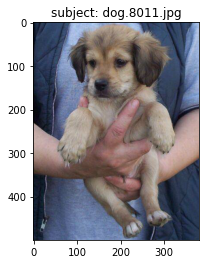

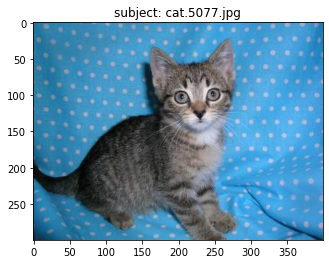

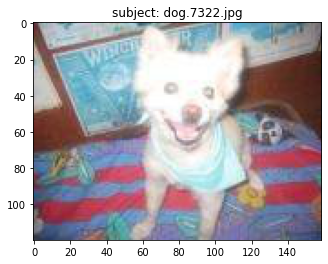

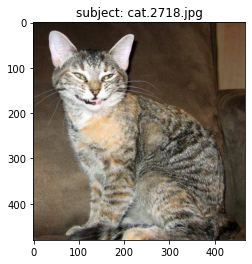

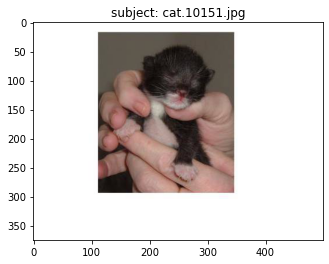

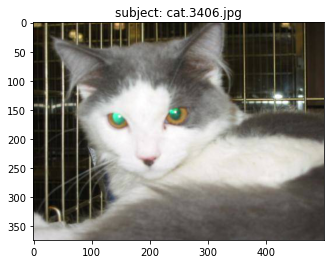

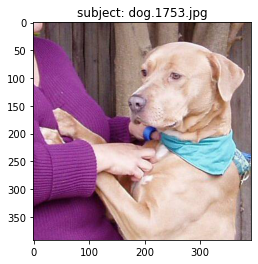

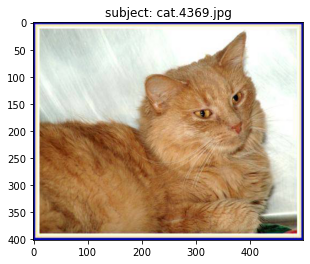

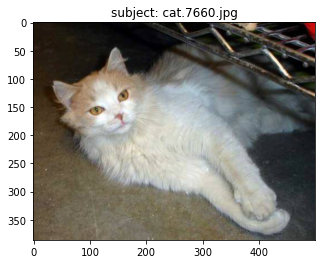

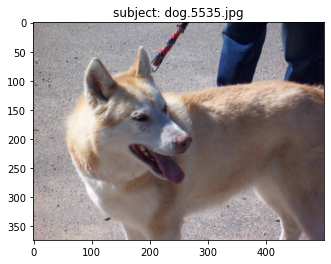

In [ ]:
path_subjects = "../DATA/dogs-vs-cats/train"
for f_name in os.listdir(path_subjects):
    img = Image.open(path_subjects + '/' + f_name)
    plt.imshow(img, vmin=0, vmax=255)
    plt.title('subject: ' + str(f_name))
    plt.show()

In [ ]:
experiment_rootdir = "./CNN-results-simple/"
weights_path = './CNN-results-simple/weights.h5'
loss_img_name = './CNN-results-simple/loss.png'
accuracy_img_name = './CNN-results-simple/accuracy.png'

weights_file = Path(weights_path)

In [ ]:
# Randomize the initial network weights
random_seed = True

# Parameters that characterizes the images, size and image type
img_width=128
img_height=128
img_channels=3
img_mode='rgb'

# Parameters that configures the training process
batch_size=32
epochs = 10
lrate = 0.001
min_lrate = 0.00001

In [ ]:
filenames=os.listdir("../DATA/dogs-vs-cats/train")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
def createSimpleNetwork(img_width,img_height,img_channels):
    model=Sequential()
    
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width,img_height,img_channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    
    return model

In [ ]:
def createNetworkVGG16(img_width,img_height,img_channels):
    #  dropout rate for FC layers
    dropout=0.5

    # CNN architecture

    input_image = Input(shape=(32,32,3))
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Flatten()(x1)

    x=Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(x1)
    x=Dropout(dropout)(x)

    out= Dense(num_classes, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out);
    return model

In [ ]:
def createNetworkResnet(img_width,img_height,img_channels):
    #  dropout rate for FC layers
    dropout=0.5

    # CNN architecture

    input_image = Input(shape=(32,32,3))
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x2 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(128, (3, 3),padding='same')(x2)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(256, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(256, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(512, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(512, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(512, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(512, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Flatten()(x1)
    x=Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(x1)
    x=Dropout(dropout)(x)

    out= Dense(num_classes, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out);
    
    return model

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df ,validate_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]


In [ ]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

#Using ImageGenerator
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "../DATA/dogs-vs-cats/train/",
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=(img_width,img_height),
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    color_mode=img_mode,
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../DATA/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

test_generator = test_datagen.flow_from_dataframe(train_df,
                                                 "../DATA/dogs-vs-cats/test/",
                                                  x_col='filename',
                                                  y_col='category',
                                                  target_size=(img_width,img_height),
                                                  class_mode='categorical',
                                                  batch_size=batch_size,
                                                  color_mode=img_mode,
                                                 )

In [ ]:
def trainModel(model):
    
    #probar otro compiler con otro optimizer en función del modelo que entrenemos
    #sdg = SGD(lr=lrate, momentum=0.9, decay=1e-6, nesterov=True)
    #adam = Adam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    rmsprop = RMSprop(learning_rate=lrate, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
    model.compile(loss='categorical_crossentropy', optimizer= rmsprop ,metrics=['accuracy'])
    print(model.summary())
    
    
    # Define training and validation steps taking into account the number of samples for each process and the batch size    
    STEPS_PER_EPOCH_TRAINING =  total_train// batch_size
    STEPS_PER_EPOCH_VALIDATION =  total_validate// batch_size
    
    # Fit the model by using the fit generator
    earlystop = EarlyStopping(patience = 10)
    learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5, min_lr = min_lrate)
    history = model.fit_generator(
        train_generator, 
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        callbacks=[earlystop,learning_rate_reduction]
    )
    return history

In [ ]:
simpleModel = createSimpleNetwork(img_width,img_height,img_channels)
#vggModel = createNetworkVGG16(img_width,img_height,img_channels)
#resnetModel = createNetworkResnet(img_width,img_height,img_channels)
history = trainModel(simpleModel)
simpleModel.save_weights(weights_path)

In [ ]:
test_filenames = os.listdir("../DATA/dogs-vs-cats/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
# Create the model by using the getModel function
simpleModel = createSimpleNetwork(img_width,img_height,img_channels)
#vggModel = createNetworkVGG16(img_width,img_height,img_channels)
#resnetModel = createNetworkResnet(img_width,img_height,img_channels)
# Load saved weights
weights_load_path = os.path.join(experiment_rootdir, weights_path)

try:
    simpleModel.load_weights(weights_load_path)
    print("Loaded model from {}".format(weights_load_path))
except:
    print("Impossible to find weight path. Returning untrained model")

# Compile model
#sgd = SGD(lr=initial_lr, momentum=0.9, decay=decay, nesterov=False)
#adam = Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
rmsprop = RMSprop(learning_rate=lrate, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Get predictions using predict_generator function
STEPS_PER_EPOCH_TEST = np.ceil(nb_samples//batch_size)
predict = simpleModel.predict_generator(test_generator, steps=STEPS_PER_EPOCH_TEST)

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../DATA/dogs-vs-cats/test/"+filename, target_size=(img_width,img_height))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
results={
    0:'cat',
    1:'dog'
}

im=Image.open("__image_path_TO_custom_image")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
accuracy_path = os.path.join(experiment_rootdir, 'accuracy.png')
plt.savefig(accuracy_path)

# Show figure
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
loss_path = os.path.join(experiment_rootdir, 'loss.png')
plt.savefig(loss_path)

# Show figure
plt.show()